This notebook is the process of creating the automatically constructed ontology with clustering

Pre-processing of data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re
from sentence_transformers import SentenceTransformer
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster
import nltk
from word2number import w2n

ModuleNotFoundError: No module named 'pandas'

In [2]:
import numpy as np

ModuleNotFoundError: No module named 'numpy'

In [2]:

# Removing time measures from endpoint data
def remove_time_measures(text):
    time_units = ['day', 'week', 'month', 'year']
    time_units += [unit + 's' for unit in time_units]
    pattern = r'\b\d*\s*(' + '|'.join(time_units) + r')\b'
    new_text = re.sub(pattern, '', text)
    new_text = re.sub(r'\d-\s', '', new_text)
    
    return new_text

# Converting the word representation of numbers into integers
def word_to_num(text):
    words = text.split()
    new_words = []
    for word in words:
        try:
            number = w2n.word_to_num(word)
            new_words.append(str(number))
        except ValueError:
            new_words.append(word)
    new_text = ' '.join(new_words)
    return new_text

#Remove the last word until the endpoint ends with a noun
def remove_until_noun(text):
    words = text.split()
    while len(words) > 1:
        pos = nltk.pos_tag(words)
        last_word, last_pos = pos[-1]
        if last_pos.startswith('NN'):
            break
        else:
            words = words[:-1]
    new_text = ' '.join(words)
    return new_text

def process_text(text):
    text = word_to_num(text)
    text = remove_time_measures(text)
    text = remove_until_noun(text)
    return text

#Split the endpoints by the first ',', ':' or "("
def extract_keywords(sentence, max_words=30):
    words = sentence.split(",")
    words_before_colon = words[0]
    if ":" in words_before_colon:
        words_after_colon = re.sub(r'\([^)]*\)', '', words_before_colon.split(":")[1])
        filtered_words = [w.strip() for w in words_after_colon.lower().split()][:max_words]
    elif "(" in words_before_colon:
        words_before_bracket = words_before_colon.split("(")[0]
        filtered_words = [w.strip() for w in words_before_bracket.lower().split()][:max_words]
    else:
        filtered_words = [w.strip() for w in words_before_colon.lower().split()][:max_words]
    return ' '.join(filtered_words)


df = pd.read_csv('ctg-studies.csv')
outcome_measures = df.iloc[:300, 2]

# Removing duplicates
outcome_measures.dropna(inplace=True)

outcome_measures_keywords = outcome_measures.apply(lambda x: extract_keywords(str(x)))

outcome_measures_processed = outcome_measures_keywords.apply(process_text)




This extracts the pre-processed outcome measures into a text file

In [3]:

with open('outcome_measures.txt', 'w', encoding='utf-8') as f:
    for measure in outcome_measures_processed:
        # write each measure on a new line
        f.write(measure + '\n')

In [ ]:
Importing the text file

In [33]:
sentences = []

with open('ai_processed_measures.txt', 'r') as file:
    for line in file:
        sentence = line.rstrip('.\n')  
        sentences.append(sentence)

sentences = list(set(sentences))

Sentence embeddings

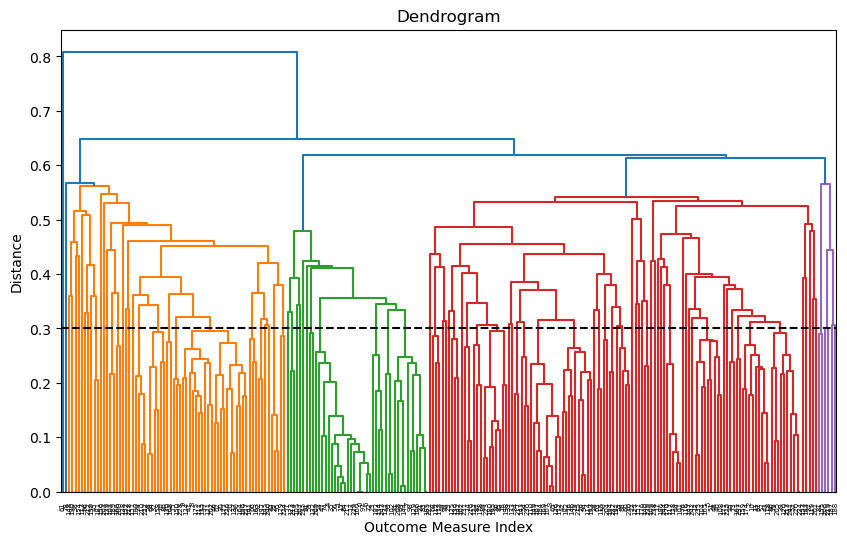

In [49]:
# Define the predefined labels
labels = ["Measure of quality of life",
    "Measure of patient satisfaction",
    "Measure of tolerability",
    "Measure of adherence",
    "Measure of costs",
    "Measure of efficacy",
    "Measure of healthcare resource utilization",
    "Measure of neurocognitive function",
    "Measure of nutritional status",
    "Measure of patient preference",
    "Measure of performance status",
    "Measure of sexual function",
    "Measure of safety"]


# Cluster the data using sentence embeddings and hierarchial clustering
model = SentenceTransformer('bert-base-nli-mean-tokens')
outcome_measures = sentences  # Convert the outcome measure sentences to a list
sentence_embeddings = model.encode(outcome_measures)
Z = linkage(sentence_embeddings, metric='cosine', method='average')


plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.axhline(y=0.3, color='k', linestyle='--')  # Cutoff point linw
plt.xlabel('Outcome Measure Index')
plt.ylabel('Distance')
plt.title('Dendrogram')
plt.savefig('dendrogram.png', dpi=300, format='png')
plt.show()




In [ ]:
cutoff_height = 0.3  # Determine the cutoff height based on the dendrogram analysis
clusters = fcluster(Z, t=cutoff_height, criterion='distance')

outcome_measures_clustered = pd.DataFrame({'Outcome Measure': outcome_measures, 'Cluster': clusters})

Topic modeling 

In [43]:
# Prepare data for LDA
vectorizer_outcome = CountVectorizer()
vectorizer_labels = CountVectorizer()

X_outcome = vectorizer_outcome.fit_transform(outcome_measures)
X_labels = vectorizer_labels.fit_transform(labels)

# Fit LDA models
lda_model_outcome = LatentDirichletAllocation(n_components=13, random_state=0)
lda_model_outcome.fit(X_outcome)
topics = lda_model_outcome.transform(X_outcome)

lda_model_labels = LatentDirichletAllocation(n_components=len(labels), random_state=0)  # assuming each label represents a different topic
lda_model_labels.fit(X_labels)

# Extract keywords from outcome measures
feature_names_outcome = vectorizer_outcome.get_feature_names_out()
keywords_per_topic_outcome = []
for topic_idx, topic in enumerate(lda_model_outcome.components_):
    keywords_per_topic_outcome.append([feature_names_outcome[i] for i in topic.argsort()[:-6:-1]])

# Extract keywords from labels
feature_names_labels = vectorizer_labels.get_feature_names_out()
keywords_per_topic_labels = []
for topic_idx, topic in enumerate(lda_model_labels.components_):
    keywords_per_topic_labels.append([feature_names_labels[i] for i in topic.argsort()[:-6:-1]])

# Calculate similarity between the extracted keywords from outcomes and labels
similarity_scores_per_cluster = []
for cluster_id in outcome_measures_clustered['Cluster'].unique():
    cluster_topic_idx = topics[outcome_measures_clustered[outcome_measures_clustered['Cluster'] == cluster_id].index[0]].argmax()
    cluster_keywords = keywords_per_topic_outcome[cluster_topic_idx]
    cluster_keywords_embedding = model.encode(cluster_keywords)
    cluster_keywords_embedding_mean = np.mean(cluster_keywords_embedding, axis=0)
    
    label_similarity_scores = []
    for label_keywords in keywords_per_topic_labels:
        label_keywords_embedding = model.encode(label_keywords)
        label_keywords_embedding_mean = np.mean(label_keywords_embedding, axis=0)
        label_similarity_scores.append(cosine_similarity([cluster_keywords_embedding_mean], [label_keywords_embedding_mean])[0][0])

    similarity_scores_per_cluster.append(label_similarity_scores)

# Assign labels based on the highest similarity score and a threshold of 0.5
label_threshold = 0.5

labels_per_outcome = []
for cluster_id in outcome_measures_clustered['Cluster']:
    similarity_scores = np.array(similarity_scores_per_cluster[cluster_id-1])
    max_score_idx = similarity_scores.argmax()
    max_score = similarity_scores[max_score_idx]
    if max_score > label_threshold:
        labels_per_outcome.append(labels[max_score_idx])

# Add the labels column to the outcome_measures_clustered dataframe
outcome_measures_clustered['Label'] = labels_per_outcome

# Merge the clusters using the pandas concat function
merged_clusters = pd.concat([outcome_measures_clustered.groupby('Label')['Outcome Measure'].agg(list), outcome_measures_clustered.groupby('Label').size()], axis=1).reset_index()
merged_clusters.columns = ['Label', 'Outcome Measure', 'Size']

# Print the merged clusters
merged_clusters


,Label,Outcome Measure,Size
0,Measure of efficacy,"[Operative time, Rate of a positive result, De...",128
1,Measure of patient satisfaction,"[Progression-free survival, Incidence of adver...",58
2,Measure of performance status,"[Disease-free survival rate, Participants achi...",59


Exporting it as an ontology

In [44]:
from owlready2 import *
import types
import re

# Create a new ontology
ontology = get_ontology("http://example.com/ontology.owl")

# List of desired class labels
desired_labels = [
    "Measure of quality of life",
    "Measure of patient satisfaction",
    "Measure of tolerability",
    "Measure of adherence",
    "Measure of costs",
    "Measure of efficacy",
    "Measure of healthcare resource utilization",
    "Measure of neurocognitive function",
    "Measure of nutritional status",
    "Measure of patient preference",
    "Measure of performance status",
    "Measure of sexual function",
    "Measure of safety",
]

with ontology:
    # For each desired label
    for label in desired_labels:
        # Clean up the label name to be a valid class name
        label_class_name = re.sub('\W|^(?=\d)','_', label)
        # Create a new OWL class for this label
        LabelClass = types.new_class(label_class_name, (Thing,))
        # Append original label name as rdfs:label
        LabelClass.label.append(label)
        # Get the outcome measures for this label
        cluster_outcomes = merged_clusters[merged_clusters['Label'] == label]['Outcome Measure']
        # For each outcome measure list
        for outcome_list in cluster_outcomes:
            # For each outcome in the list
            for outcome in outcome_list:
                # Clean up the outcome name to be a valid class name
                outcome_class_name = re.sub('\W|^(?=\d)','_', outcome)
                # Create a new OWL class for this outcome measure, as a subclass of LabelClass
                OutcomeClass = types.new_class(outcome_class_name, (LabelClass,))
                # Append original outcome name as rdfs:label
                OutcomeClass.label.append(outcome)

# Save the ontology to an OWL file
ontology.save(file = "clustered_ontology.owl", format = "rdfxml")
